In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install tensorflow_addons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer,TFBertModel
import tensorflow as tf

from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization,Embedding,LSTM,Bidirectional
from tensorflow.keras.models import Model

from tensorflow_addons.metrics import F1Score
from sklearn.metrics import f1_score

     |████████████████████████████████| 3.1 MB 4.0 MB/s 
     |████████████████████████████████| 596 kB 41.9 MB/s 
     |████████████████████████████████| 895 kB 40.7 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Xeeva/bert_sample.xlsx')

In [ ]:
print(data.shape)
display(data.head())

(10000, 2)


,ITEM_NAME,CATEGORY_ID
0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY
1,for pusher whskey,CAPITAL ASSEMBLY
2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY
3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


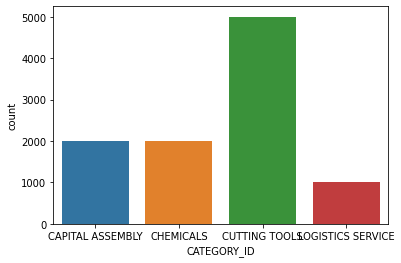

In [ ]:
sns.countplot(data['CATEGORY_ID'])

In [ ]:
import string
special_chars = string.punctuation

def counts(txt):
    c,l,d,sp=0,0,0,0
    space = txt.count(" ")
    for ch in txt:
        if ch.islower():
            l+=1
        elif ch.isupper():
            c+=1
        elif ch.isdigit():
            d+=1
        elif ch in special_chars:
            sp+=1
    return np.array([c,l,space,d,sp,len(txt),len(txt.split())])

In [ ]:
data['temp'] = data['ITEM_NAME'].apply(lambda x : counts(x))

In [ ]:
data = pd.concat([data,pd.DataFrame(np.vstack(data['temp'].values),columns=['cap','low','space','digit','spe','len','char'])],1)
data = data.drop(columns=['temp'])
data.head()

,ITEM_NAME,CATEGORY_ID,cap,low,space,digit,spe,len,char
0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY,21,2,4,2,0,29,4
1,for pusher whskey,CAPITAL ASSEMBLY,0,15,3,0,0,18,3
2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY,16,47,17,5,1,86,17
3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY,7,8,4,10,3,32,4
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY,44,0,12,25,5,86,12


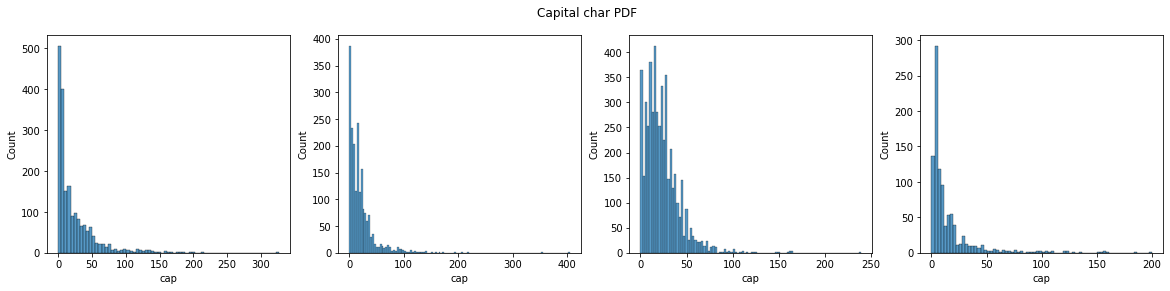

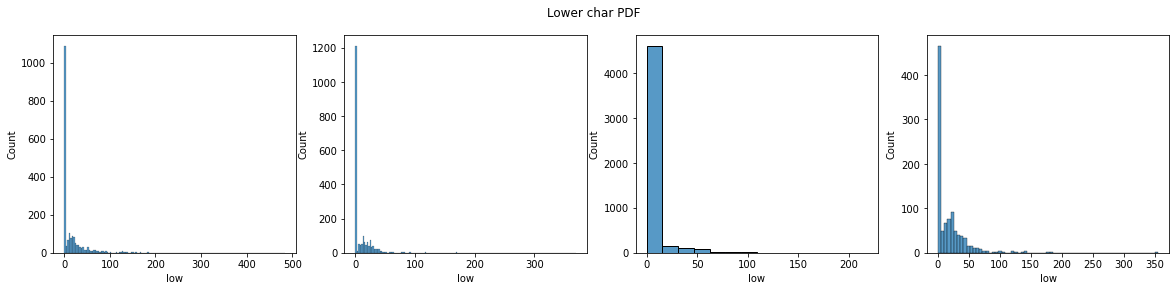

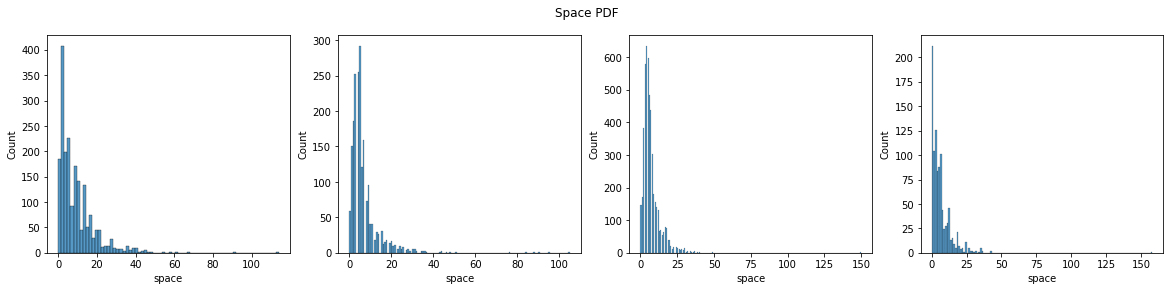

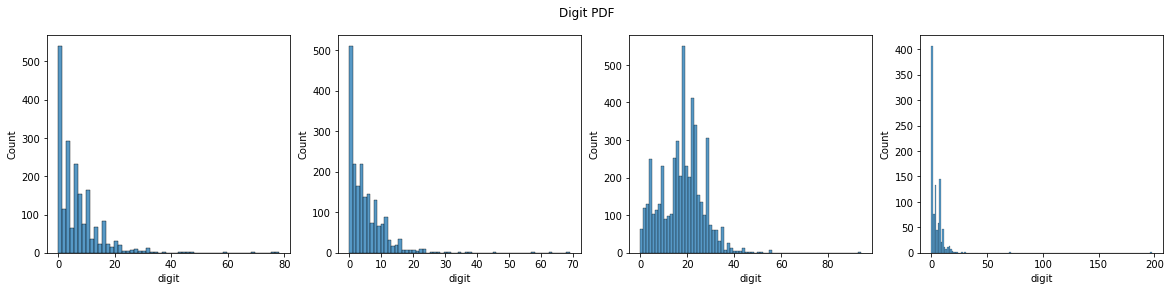

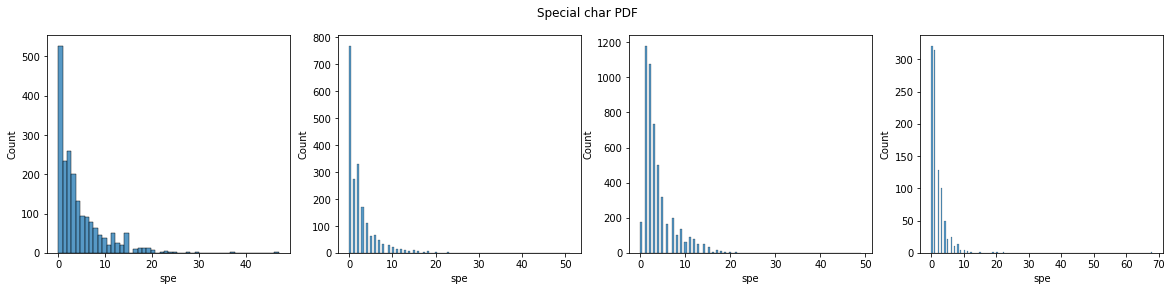

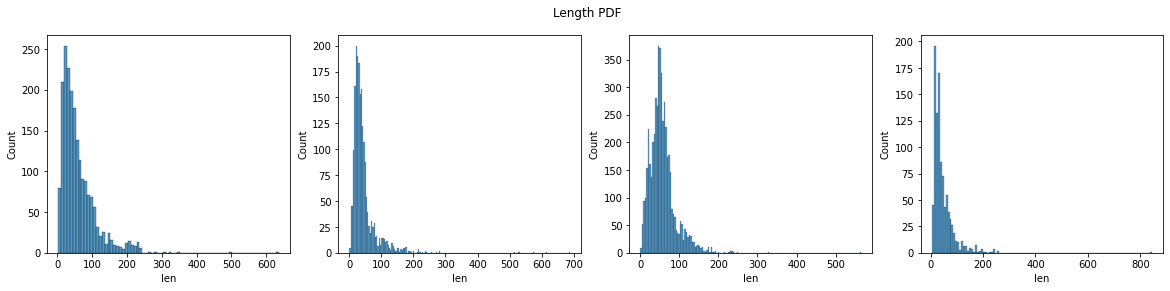

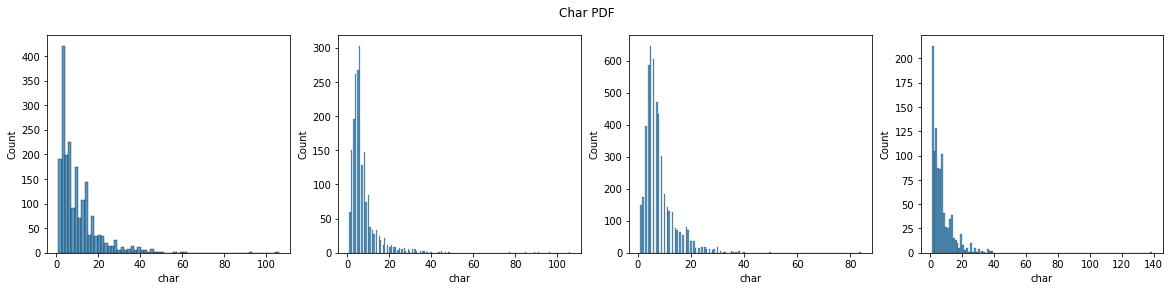

In [ ]:
fig,pl = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(data['CATEGORY_ID'].unique()):
    sns.histplot(data[data['CATEGORY_ID']==col]['cap'],ax=pl[i])
fig.suptitle('Capital char PDF')
plt.show()

fig,pl = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(data['CATEGORY_ID'].unique()):
    sns.histplot(data[data['CATEGORY_ID']==col]['low'],ax=pl[i])
fig.suptitle('Lower char PDF')
plt.show()

fig,pl = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(data['CATEGORY_ID'].unique()):
    sns.histplot(data[data['CATEGORY_ID']==col]['space'],ax=pl[i])
fig.suptitle('Space PDF')
plt.show()

fig,pl = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(data['CATEGORY_ID'].unique()):
    sns.histplot(data[data['CATEGORY_ID']==col]['digit'],ax=pl[i])
fig.suptitle('Digit PDF')
plt.show()

fig,pl = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(data['CATEGORY_ID'].unique()):
    sns.histplot(data[data['CATEGORY_ID']==col]['spe'],ax=pl[i])
fig.suptitle('Special char PDF')
plt.show()

fig,pl = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(data['CATEGORY_ID'].unique()):
    sns.histplot(data[data['CATEGORY_ID']==col]['len'],ax=pl[i])
fig.suptitle('Length PDF')
plt.show()

fig,pl = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(data['CATEGORY_ID'].unique()):
    sns.histplot(data[data['CATEGORY_ID']==col]['char'],ax=pl[i])
fig.suptitle('Char PDF')
plt.show()

* As per above plots we can see that mostly feature's PDF overlaping with each other but digit geature has some information to predict the target.
* so we can convert uppercase to lowercase
* digits we will keep as it is because it is usefull

In [ ]:
data = data[['ITEM_NAME','CATEGORY_ID']]
cat_encode = {
    'CAPITAL ASSEMBLY':0, 
    'CHEMICALS':1,
    'CUTTING TOOLS':2,
    'LOGISTICS SERVICE':3
}
data['CATEGORY_ID'] = data.CATEGORY_ID.map(cat_encode)
data['ITEM_NAME'] = data['ITEM_NAME'].str.lower()


def punc(txt):
  for ch in string.punctuation:
    txt = txt.replace(ch,f" {ch} ")
  return txt

data['ITEM_NAME'] = data['ITEM_NAME'].apply(punc)
data['ITEM_NAME'] = data['ITEM_NAME'].apply(lambda txt : re.sub(' +', ' ', txt))
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,ITEM_NAME,CATEGORY_ID
0,calibracion transducer 75 nm,0
1,for pusher whskey,0
2,stat 40b press head cup to carrier from stati...,0
3,transd . cable ( 4145097103 ) scrw,0
4,"zt200 7 , 5bar , 13bar60hz numero de serie : ...",0


In [ ]:
chars = set(re.sub("[a-zA-Z0-9]", "", " ".join(data['ITEM_NAME'].values.reshape(1,-1)[0]))) - set(string.punctuation)
print(chars)

{'´', '示', 'û', '件', '–', '‚', '轴', '©', '涂', 'ã', '丝', '›', 'í', 'ö', '\x94', '®', 'ą', '\xa0', '轮', 'å', ' ', '“', '组', 'ü', '电', 'ç', '°', '”', '€', '\x92', '\n', '\r', '钻', '达', 'ś', '马', '’', 'ú', '锥', '桶', '层', 'è', 'ò', '器', '头', '±', 'ù', 'á', 'œ', '¢', '‘', 'ł', '\x9d', 'ę', 'ø', '¼', 'ż', '�', 'ó', '教', 'é', '链', 'ñ', 'º', '½', '\x81', '•', 'ì', '¨', '³', '\x96', 'â', '套', '缆'}


In [ ]:
chars = chars - {'å', '缆', 'ú', '教', 'û',  '桶',  '达',  '½', '©', '链', 'í',  '涂', '层', '钻', 'é', 'ø', '器', '°', 'ñ', 'ż', '锥', 'ü', '€',  '马', 'ã', 'œ', 'ì', '头', '•', '¼', '丝', 'ö',  '套', '轴', 'ś', 'ò',  '\x92', 'ę', '¢',  '轮', 'â', 'ą', 'ó', 'ç', 'è', 'ł', '组', '±', '电', '³', '示', 'º', 'ù', '件', '›', '®', 'á'}
print(chars)

{'´', '\xa0', '–', '‚', ' ', '“', '\x81', '�', '¨', '‘', '”', '\x9d', '\n', '\x96', '\r', '\x94', '’'}


removing above chars from text data.

In [ ]:
def rep(txt):
    for ch in chars:
        txt = txt.replace(ch,f" {ch} ")
    return txt
data['ITEM_NAME'] = data['ITEM_NAME'].apply(rep)
data['ITEM_NAME'] = data['ITEM_NAME'].apply(lambda txt : re.sub(' +', ' ', txt))
data.head()

,ITEM_NAME,CATEGORY_ID
0,calibracion transducer 75 nm,0
1,for pusher whskey,0
2,stat 40b press head cup to carrier from stati...,0
3,transd . cable ( 4145097103 ) scrw,0
4,"zt200 7 , 5bar , 13bar60hz numero de serie : ...",0


In [ ]:
data.isna().sum()

ITEM_NAME      0
CATEGORY_ID    0
dtype: int64

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data['ITEM_NAME'],data['CATEGORY_ID'],stratify=data['CATEGORY_ID'],test_size=0.2,random_state=4444)

y_train = pd.get_dummies(data=y_train,columns=['CATEGORY_ID'])
y_test = pd.get_dummies(data=y_test,columns=['CATEGORY_ID'])

x_train.shape,x_test.shape,y_train.shape,y_test.shape

((8000,), (2000,), (8000, 4), (2000, 4))

50th percentile: 50.0
75th percentile: 73.0
90th percentile: 111.0
95th percentile: 141.0
96th percentile: 151.0
97th percentile: 161.0
98th percentile: 180.0
99th percentile: 217.01000000000022
99.5th percentile: 243.01500000000033
99.75th percentile: 260.0
99.85th percentile: 300.0479999999807
99.90th percentile: 530.026000000029
99.99th percentile: 790.6177999998417
100th percentile: 933.0


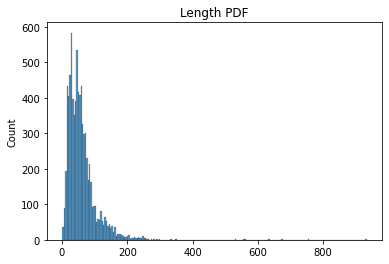

In [ ]:
length = np.array([len(t) for t in x_train])

print(f"50th percentile: {np.percentile(length,50)}")
print(f"75th percentile: {np.percentile(length,75)}")
print(f"90th percentile: {np.percentile(length,90)}")
print(f"95th percentile: {np.percentile(length,95)}")
print(f"96th percentile: {np.percentile(length,96)}")
print(f"97th percentile: {np.percentile(length,97)}")
print(f"98th percentile: {np.percentile(length,98)}")
print(f"99th percentile: {np.percentile(length,99)}")
print(f"99.5th percentile: {np.percentile(length,99.5)}")
print(f"99.75th percentile: {np.percentile(length,99.75)}")
print(f"99.85th percentile: {np.percentile(length,99.85)}")
print(f"99.90th percentile: {np.percentile(length,99.9)}")
print(f"99.99th percentile: {np.percentile(length,99.99)}")
print(f"100th percentile: {np.percentile(length,100)}")

sns.histplot(length)
plt.title("Length PDF")
plt.show()

as per above 99.85% data has length 300 or less than thas so we can use MAX LENGTH 300.

In [ ]:
print(length[length>300])
print(len(length[length>300]))

[561 933 556 332 345 674 634 755 351 530 563 633]
12


In [ ]:
MAX_LEN = 300

In [ ]:
np.sum(y_train)

0    1600
1    1600
2    4000
3     800
dtype: int64

Data is unbalanced so lets upsample the data.

In [ ]:
x = x_train[y_train[3]==1]
y = y_train[y_train[3]==1]

for i in range(4):
    x_train = pd.concat([x_train,x])
    y_train = pd.concat([y_train,y])


x = x_train[y_train[0]==1]
y = y_train[y_train[0]==1]
x_train = pd.concat([x_train,x])
y_train = pd.concat([y_train,y])
x_train = pd.concat([x_train,x[:800]])
y_train = pd.concat([y_train,y[:800]])

x = x_train[y_train[1]==1]
y = y_train[y_train[1]==1]
x_train = pd.concat([x_train,x])
y_train = pd.concat([y_train,y])
x_train = pd.concat([x_train,x[:800]])
y_train = pd.concat([y_train,y[:800]])

np.sum(y_train)

0    4000
1    4000
2    4000
3    4000
dtype: int64

In [3]:
# np.save('/content/drive/MyDrive/Colab Notebooks/Xeeva/x_train.npy',x_train)
# np.save('/content/drive/MyDrive/Colab Notebooks/Xeeva/y_train.npy',y_train)
# np.save('/content/drive/MyDrive/Colab Notebooks/Xeeva/x_test.npy',x_test)
# np.save('/content/drive/MyDrive/Colab Notebooks/Xeeva/y_test.npy',y_test)


x_train =  np.load('/content/drive/MyDrive/Colab Notebooks/Xeeva/x_train.npy',allow_pickle=True)
y_train =  np.load('/content/drive/MyDrive/Colab Notebooks/Xeeva/y_train.npy',allow_pickle=True)
x_test =  np.load('/content/drive/MyDrive/Colab Notebooks/Xeeva/x_test.npy',allow_pickle=True)
y_test =  np.load('/content/drive/MyDrive/Colab Notebooks/Xeeva/y_test.npy',allow_pickle=True)
MAX_LEN = 300

In [ ]:
def get_sequence(txt, max_len,tokenizer):
    data = tokenizer(
        txt.tolist() ,
        return_attention_mask=False,
        return_token_type_ids=False,
        max_length=max_len,
        truncation=True,
        padding='max_length'
    )['input_ids']
    return np.array(data)

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

x_train = get_sequence(x_train, MAX_LEN,tokenizer)
x_test = get_sequence(x_test, MAX_LEN,tokenizer)

x_train.shape,x_test.shape

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

((16000, 300), (2000, 300))

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, data,y, batch_size=1):
        self.data = data
        self.y = y
        self.indexes = np.arange(len(self.data))
        self.batch_size = batch_size
 
 
    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
 
        data = self.data[start:stop,:]
        y = self.y[start:stop]
        attention = (data>0).astype(int)
 
        return tuple([[data,attention],y])
 
    def __len__(self):
        return len(self.indexes) // self.batch_size

In [ ]:
BATCH_SIZE = 16
train_dataloader = Dataloder(x_train,y_train,BATCH_SIZE)
test_dataloader = Dataloder(x_test,y_test,BATCH_SIZE)

##BERT

In [ ]:
bert = TFBertModel.from_pretrained('bert-base-cased')
def create_model(berttrain = False):
    input_ids = Input((MAX_LEN,),dtype=tf.int32)
    attention_mask = Input((MAX_LEN,),dtype=tf.int32)
 
 
    bert_out = bert(input_ids=input_ids, attention_mask=attention_mask)[1]
    x = Dense(32,activation='relu')(bert_out)
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)
    output = Dense(4,activation='softmax')(x)
 
    model = Model([input_ids,attention_mask],output)
    model.layers[3].trainable=berttrain
 
    return model

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)
model.compile(optimizer=optimizer,loss='categorical_crossentropy')
 
model.fit(train_dataloader,epochs=5,validation_data=test_dataloader)
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Xeeva/bert.h5")

Epoch 1/5
1000/1000 [==============================] - 2065s 2s/step - loss: 1.3070 - val_loss: 0.6780
Epoch 2/5
1000/1000 [==============================] - 2025s 2s/step - loss: 1.1796 - val_loss: 0.5799
Epoch 3/5
1000/1000 [==============================] - 2016s 2s/step - loss: 1.1544 - val_loss: 0.5420
Epoch 4/5
1000/1000 [==============================] - 2017s 2s/step - loss: 1.1356 - val_loss: 0.5298
Epoch 5/5
1000/1000 [==============================] - 2019s 2s/step - loss: 1.1313 - val_loss: 0.5196


In [ ]:
model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)
model.compile(optimizer=optimizer,loss='categorical_crossentropy')

model.load_weights("/content/drive/MyDrive/Colab Notebooks/Xeeva/bert.h5")

model.fit(train_dataloader,epochs=5,validation_data=test_dataloader)
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Xeeva/bert1.h5")

Epoch 1/5
1000/1000 [==============================] - 1990s 2s/step - loss: 1.1385 - val_loss: 0.4407
Epoch 2/5
1000/1000 [==============================] - 1943s 2s/step - loss: 1.0950 - val_loss: 0.4465
Epoch 3/5
1000/1000 [==============================] - 1939s 2s/step - loss: 1.0831 - val_loss: 0.4250
Epoch 4/5
1000/1000 [==============================] - 1941s 2s/step - loss: 1.0628 - val_loss: 0.3989
Epoch 5/5
1000/1000 [==============================] - 1942s 2s/step - loss: 1.0649 - val_loss: 0.4034


In [ ]:
test_dataloader.batch_size = 4000
pred = model.predict(test_dataloader[0][0])
for i in range(len(pred)):
    j = np.argmax(pred[i,:])
    pred[i,:] = 0
    pred[i,j] = 1

print("Test F1-Score for each of the class")
print(f1_score(pred,test_dataloader[0][1],average=None))


train_dataloader.batch_size = 16000
pred = model.predict(train_dataloader[0][0])
for i in range(len(pred)):
    j = np.argmax(pred[i,:])
    pred[i,:] = 0
    pred[i,j] = 1

print("Train F1-Score for each of the class")
print(f1_score(pred,train_dataloader[0][1],average=None))

Test F1-Score for each of the class
[0.85465839 0.84393064 0.98041185 0.64896755]
Train F1-Score for each of the class
[0.92309515 0.90412876 0.99536283 0.83333333]


BERT FineTunning

In [ ]:
model = create_model(True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)
model.compile(optimizer=optimizer,loss='categorical_crossentropy')

model.load_weights("/content/drive/MyDrive/Colab Notebooks/Xeeva/bert1.h5")
model.fit(train_dataloader,epochs=6,validation_data=test_dataloader)
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Xeeva/bert-finetuned.h5")

Epoch 1/6
1000/1000 [==============================] - 2036s 2s/step - loss: 1.0956 - val_loss: 0.4154
Epoch 2/6
1000/1000 [==============================] - 2008s 2s/step - loss: 1.0506 - val_loss: 0.3720
Epoch 3/6
1000/1000 [==============================] - 2007s 2s/step - loss: 1.0364 - val_loss: 0.3368
Epoch 4/6
1000/1000 [==============================] - 2005s 2s/step - loss: 1.0206 - val_loss: 0.3280
Epoch 5/6
1000/1000 [==============================] - 1998s 2s/step - loss: 1.0157 - val_loss: 0.3216
Epoch 6/6
1000/1000 [==============================] - 2001s 2s/step - loss: 1.0052 - val_loss: 0.3235



In [ ]:
test_dataloader.batch_size = 4000
pred = model.predict(test_dataloader[0][0])
for i in range(len(pred)):
    j = np.argmax(pred[i,:])
    pred[i,:] = 0
    pred[i,j] = 1

print("Test F1-Score for each of the class")
f1_score(pred,test_dataloader[0][1],average=None)

Test F1-Score for each of the class


array([0.87166455, 0.87640449, 0.98294885, 0.73205742])

In [ ]:
train_dataloader.batch_size = 16000
pred = model.predict(train_dataloader[0][0])
for i in range(len(pred)):
    j = np.argmax(pred[i,:])
    pred[i,:] = 0
    pred[i,j] = 1

print("Train F1-Score for each of the class")
f1_score(pred,train_dataloader[0][1],average=None)

Train F1-Score for each of the class


array([0.98339783, 0.97488442, 0.99736809, 0.96790308])

##LSTM

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization,Embedding,LSTM,Bidirectional,Input,ReLU
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [5]:
tok = Tokenizer()
tok.fit_on_texts(x_train)

In [6]:
train_seq = tok.texts_to_sequences(x_train)
test_seq = tok.texts_to_sequences(x_test)

train_seq = pad_sequences(train_seq,maxlen=MAX_LEN,dtype='int32',padding='post')
test_seq = pad_sequences(test_seq,maxlen=MAX_LEN,dtype='int32',padding='post')

train_seq.shape,y_train.shape,test_seq.shape,y_test.shape

((16000, 300), (16000, 4), (2000, 300), (2000, 4))

In [7]:
def lstm_model():
    input = Input((MAX_LEN,))
    x = Embedding(len(tok.word_index)+1,32)(input)
    x = Bidirectional(CuDNNLSTM(32))(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.8)(x)
    x = Dense(16,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    output = Dense(4,activation='softmax')(x)

    return Model(input,output)
model = lstm_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 32)           445312    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16896     
 l)                                                              
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy')
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3,verbose = 2, min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
earlystop = EarlyStopping(patience=5,restore_best_weights=True,monitor = 'val_loss')

model.fit(train_seq,y_train,epochs=40,validation_data=[test_seq,y_test],batch_size=256,callbacks=[rlr,earlystop])

Epoch 1/40
63/63 [==============================] - 16s 127ms/step - loss: 1.7935 - val_loss: 1.4000 - lr: 0.0010
Epoch 2/40
63/63 [==============================] - 7s 115ms/step - loss: 1.3168 - val_loss: 1.3977 - lr: 0.0010
Epoch 3/40
63/63 [==============================] - 7s 112ms/step - loss: 1.1079 - val_loss: 1.3142 - lr: 0.0010
Epoch 4/40
63/63 [==============================] - 7s 113ms/step - loss: 0.9770 - val_loss: 1.2009 - lr: 0.0010
Epoch 5/40
63/63 [==============================] - 7s 113ms/step - loss: 0.8571 - val_loss: 1.0799 - lr: 0.0010
Epoch 6/40
63/63 [==============================] - 7s 113ms/step - loss: 0.7459 - val_loss: 0.9391 - lr: 0.0010
Epoch 7/40
63/63 [==============================] - 7s 113ms/step - loss: 0.6540 - val_loss: 0.8050 - lr: 0.0010
Epoch 8/40
63/63 [==============================] - 7s 110ms/step - loss: 0.5754 - val_loss: 0.6288 - lr: 0.0010
Epoch 9/40
63/63 [==============================] - 7s 110ms/step - loss: 0.5169 - val_loss: 0.

In [9]:
pred = model.predict(test_seq)
for i in range(len(pred)):
    j = np.argmax(pred[i,:])
    pred[i,:] = 0
    pred[i,j] = 1
print("Test F1-Score for each of the class")
print(f1_score(pred,y_test,average=None))


pred = model.predict(train_seq)
for i in range(len(pred)):
    j = np.argmax(pred[i,:])
    pred[i,:] = 0
    pred[i,j] = 1
print("Train F1-Score for each of the class")
print(f1_score(pred,y_train,average=None))

Test F1-Score for each of the class
[0.81666667 0.76248477 0.94450154 0.78880407]
Train F1-Score for each of the class
[0.98804483 0.97883001 0.99498872 0.98438476]


###Observations:

In [12]:
print("BERT F1-score for each class:")
print([0.87166455, 0.87640449, 0.98294885, 0.73205742])
print()
print("LSTM F1-score for each class:")
print([0.81666667, 0.76248477, 0.94450154 ,0.78880407])

BERT F1-score for each class:
[0.87166455, 0.87640449, 0.98294885, 0.73205742]

LSTM F1-score for each class:
[0.81666667, 0.76248477, 0.94450154, 0.78880407]


* BERT outperforms LSTM in terms of overall performance
* BERT uses the self-attention algorithm, while LSTM uses timestamp memorization.
* As a result of a large number of parameters and a small dataset, both models are overfitted.
* BERT finetuning can easily overfit due to a large number of parameters.